## Visualisasi Awal Data: Scatterplot

Visualisasi scatterplot antara variabel **Jumlah Murid SMA** dan **PDRB Harga Konstan** dari dataset yang telah dibersihkan untuk memahami distribusi awal dari data sebelum diklasterisasi:


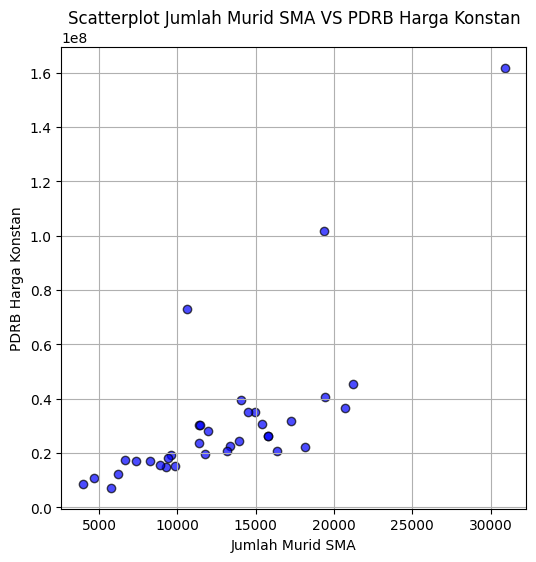

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dengan skala asli
data_clean = pd.read_csv('../../Dataset/data_cleaned.csv')

# Mengambil kolom yang akan digunakan untuk klasterisasi
X_original = data_clean[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']] 

plt.figure(figsize=(6,6))
plt.scatter(X_original['Jumlah_Murid_SMA'], X_original['PDRB_harga_konstan'], 
            c='blue', edgecolor='k', alpha=0.7)
plt.title('Scatterplot Jumlah Murid SMA VS PDRB Harga Konstan')
plt.xlabel('Jumlah Murid SMA')
plt.ylabel('PDRB Harga Konstan')
plt.grid(True)
plt.show()


## 🔧 Tuning Model DBSCAN

Untuk mendapatkan performa terbaik dari algoritma **DBSCAN**, dilakukan proses **hyperparameter tuning** terhadap dua parameter utama:

- `eps` (epsilon): Jarak maksimum antar titik untuk dianggap sebagai tetangga.
- `min_samples`: Jumlah minimum titik yang dibutuhkan untuk membentuk sebuah cluster yang valid.

### Langkah-langkah:

1. Dataset yang telah dinormalisasi dibaca dari file `data_normalized.csv`.
2. Dua fitur utama yang digunakan untuk klasterisasi adalah:
   - `Jumlah_Murid_SMA`
   - `PDRB_harga_konstan`
3. Proses tuning dilakukan dengan mencoba kombinasi `eps` dari **0.1 hingga 10.0** (interval 0.1) dan `min_samples` dari **3 hingga 10**.
4. Untuk setiap kombinasi parameter:
   - Model DBSCAN dilatih,
   - Dilakukan evaluasi dengan **Silhouette Score** dan **Davies-Bouldin Index** (jika jumlah klaster lebih dari 1),
   - Hasil evaluasi disimpan dalam sebuah list.
5. Kombinasi parameter terbaik ditentukan berdasarkan nilai **Silhouette Score** tertinggi.

### Tujuan:

Menentukan kombinasi `eps` dan `min_samples` yang memberikan pemisahan klaster terbaik berdasarkan metrik internal.



In [2]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import joblib  # untuk simpan model

# Load dataset
case_data = pd.read_csv("../../Dataset/data_normalized.csv")

# Fitur untuk clsuter
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Range nilai tuning
eps_values = np.arange(0.1, 10, 0.1)
min_samples_values = range(3, 11)

best_silhouette = -1
best_params = {}
results = []

# Proses tuning dengan for loop
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan_model.fit_predict(X_scaled)

        # Menghitung jumlah cluster (exclude noise label -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Hanya evaluasi jika cluster > 1
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
            db_score = davies_bouldin_score(X_scaled, labels)
        else:
            silhouette = -1
            db_score = np.nan

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette,
            'davies_bouldin_score': db_score
        })

        # Update parameter terbaik berdasarkan silhouette score
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters,
                           'silhouette_score': silhouette, 'davies_bouldin_score': db_score,
                           'labels': labels}

# Tampilkan semua hasil tuning dalam dataframe
results_df = pd.DataFrame(results)
results_df



,eps,min_samples,n_clusters,silhouette_score,davies_bouldin_score
0,0.1,3,0,-1.0,NaN
1,0.1,4,0,-1.0,NaN
2,0.1,5,0,-1.0,NaN
3,0.1,6,0,-1.0,NaN
4,0.1,7,0,-1.0,NaN
...,...,...,...,...,...
787,9.9,6,1,-1.0,NaN
788,9.9,7,1,-1.0,NaN
789,9.9,8,1,-1.0,NaN
790,9.9,9,1,-1.0,NaN


In [3]:
# Hasil tuning terbaik
print("\nHasil tuning terbaik:")
print(f"eps: {best_params['eps']}")
print(f"min_samples: {best_params['min_samples']}")
print(f"Jumlah cluster: {best_params['n_clusters']}")
print(f"Silhouette Score: {round(best_params['silhouette_score'], 4)}")
print(f"Davies-Bouldin Score: {round(best_params['davies_bouldin_score'], 4)}")

# Menyimpan label terbaik ke dataframe utama
case_data['Cluster_DBSCAN'] = best_params['labels']

# Menyimpan model terbaik ke file
best_dbscan_model = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
best_dbscan_model.fit(X_scaled)
joblib.dump(best_dbscan_model, 'model/model_dbscan.joblib')



Hasil tuning terbaik:
eps: 0.4
min_samples: 3
Jumlah cluster: 2
Silhouette Score: 0.3863
Davies-Bouldin Score: 0.7436


['model/model_dbscan.joblib']

## Visualisasi Hasil Clustering DBSCAN

Setelah model DBSCAN terbaik dimuat, dilakukan visualisasi hasil klasterisasi menggunakan scatter plot. Setiap klaster diberi warna berbeda, dan data yang dianggap sebagai noise ditandai dengan warna hitam. Visualisasi ini membantu melihat distribusi dan pola dari hasil klasterisasi DBSCAN secara keseluruhan.


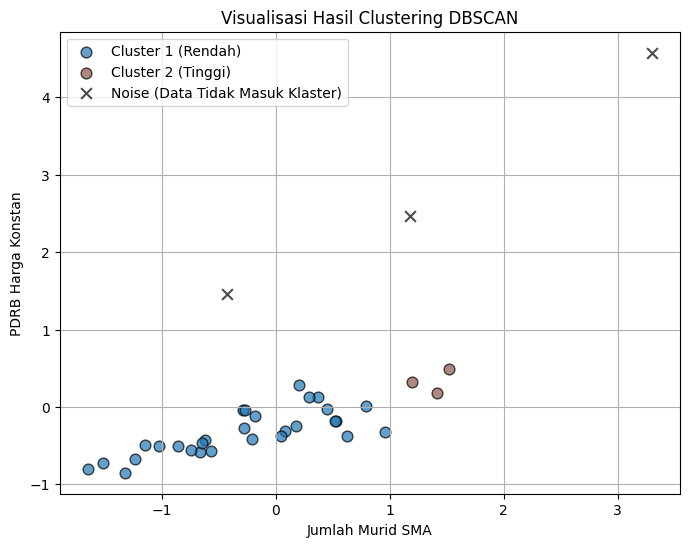

In [4]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Load model DBSCAN terbaik
best_dbscan_model = joblib.load('model/model_dbscan.joblib')

# Prediksi label menggunakan model yang tersimpan
labels = best_dbscan_model.fit_predict(X_scaled)

# Menyimpan label ke dataframe
case_data['Cluster_DBSCAN'] = labels

# Scatterplot hasil clustering
plt.figure(figsize=(8,6))

# Warna berbeda untuk tiap cluster, warna khusus untuk noise (label = -1)
unique_labels = set(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Map label ke deskripsi keterangan sesuai hasil analisis
cluster_descriptions = {
    0: 'Rendah',
    1: 'Tinggi',
    -1: 'Noise'
}

# Loop untuk visualisasi
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        label_name = 'Noise (Data Tidak Masuk Klaster)'
        marker = 'x'
        plt.scatter(X_scaled.loc[labels == k, 'Jumlah_Murid_SMA'],
                    X_scaled.loc[labels == k, 'PDRB_harga_konstan'],
                    c=[col], label=label_name, marker=marker, s=60, alpha=0.7)
    else:
        label_name = f'Cluster {k+1} ({cluster_descriptions.get(k, "Tidak Diketahui")})'
        marker = 'o'
        plt.scatter(X_scaled.loc[labels == k, 'Jumlah_Murid_SMA'],
                    X_scaled.loc[labels == k, 'PDRB_harga_konstan'],
                    c=[col], label=label_name, marker=marker, edgecolors='k', s=60, alpha=0.7)

plt.title('Visualisasi Hasil Clustering DBSCAN')
plt.xlabel('Jumlah Murid SMA')
plt.ylabel('PDRB Harga Konstan')
plt.legend()
plt.grid(True)
plt.show()


## Peta Interaktif Hasil Clustering DBSCAN

Visualisasi berikut menampilkan hasil klasterisasi DBSCAN pada peta interaktif menggunakan koordinat geografis (latitude dan longitude). Setiap wilayah diberi warna dan label sesuai klaster hasil model, sementara data yang tidak termasuk klaster (noise) ditandai dengan simbol silang (✕) berwarna hitam. Peta ini membantu memahami distribusi spasial dari hasil klasterisasi secara lebih intuitif.


In [5]:
import pandas as pd
import folium
import joblib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Load dataset
case_data = pd.read_csv("../../Dataset/data_normalized.csv")

# Load model DBSCAN terbaik
dbscan_model = joblib.load('model/model_dbscan.joblib')

# Fitur untuk prediksi
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Prediksi cluster dengan model DBSCAN
dbscan_labels = dbscan_model.fit_predict(X_scaled)

# Menyimpan label ke dataframe
case_data['Cluster_DBSCAN'] = dbscan_labels

# Label unik (termasuk noise -1)
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # jumlah cluster tanpa noise

# Colormap untuk cluster (exclude noise)
colormap = plt.get_cmap('tab10', n_clusters)

# Map warna untuk tiap cluster (mulai dari 0 cluster)
cluster_colors = {label: mcolors.to_hex(colormap(i)) for i, label in enumerate(sorted(l for l in unique_labels if l != -1))}
# Warna hitam untuk noise (-1)
cluster_colors[-1] = '#000000'

# Setup pusat peta (mean lat, long)
map_center = [case_data['latitude'].mean(), case_data['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=8)

# Marker dengan warna dan label sesuai cluster
for idx, row in case_data.iterrows():
    cluster_label = row['Cluster_DBSCAN']
    color = cluster_colors.get(cluster_label, 'gray')

    # Marker untuk noise
    if cluster_label == -1:
        icon_html = f"""
            <div style="
                font-size: 14pt;
                color: {color};
                font-weight: bold;
                text-align: center;
                line-height: 24px;
            ">✕</div>
        """
    else:
        # Custom Icon Cluster
        icon_html = f"""
            <div style="
                font-size: 12pt;
                color: white;
                background-color: {color};
                border-radius: 50%;
                width: 24px;
                height: 24px;
                text-align: center;
                line-height: 24px;
                border: 2px solid white;
            ">
                {cluster_label + 1}
            </div>
        """

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['kab_kota']} (Cluster {cluster_label if cluster_label != -1 else 'Noise'})",
        icon=folium.DivIcon(html=icon_html)
    ).add_to(m)

m.save('../../Output/DBSCAN_map.html')

m 


## Visualisasi Spasial Klaster DBSCAN pada Peta Wilayah

Visualisasi ini menampilkan hasil klasterisasi DBSCAN dalam bentuk peta wilayah kabupaten/kota di Jawa Tengah. Setiap wilayah diwarnai berdasarkan klaster yang diperoleh, dengan warna khusus abu-abu untuk data yang dianggap sebagai noise. Titik koordinat lokasi juga ditampilkan untuk memperjelas posisi geografis masing-masing daerah. Peta ini memberikan gambaran distribusi spasial dari klaster berdasarkan indikator Jumlah Murid SMA dan PDRB Harga Konstan.


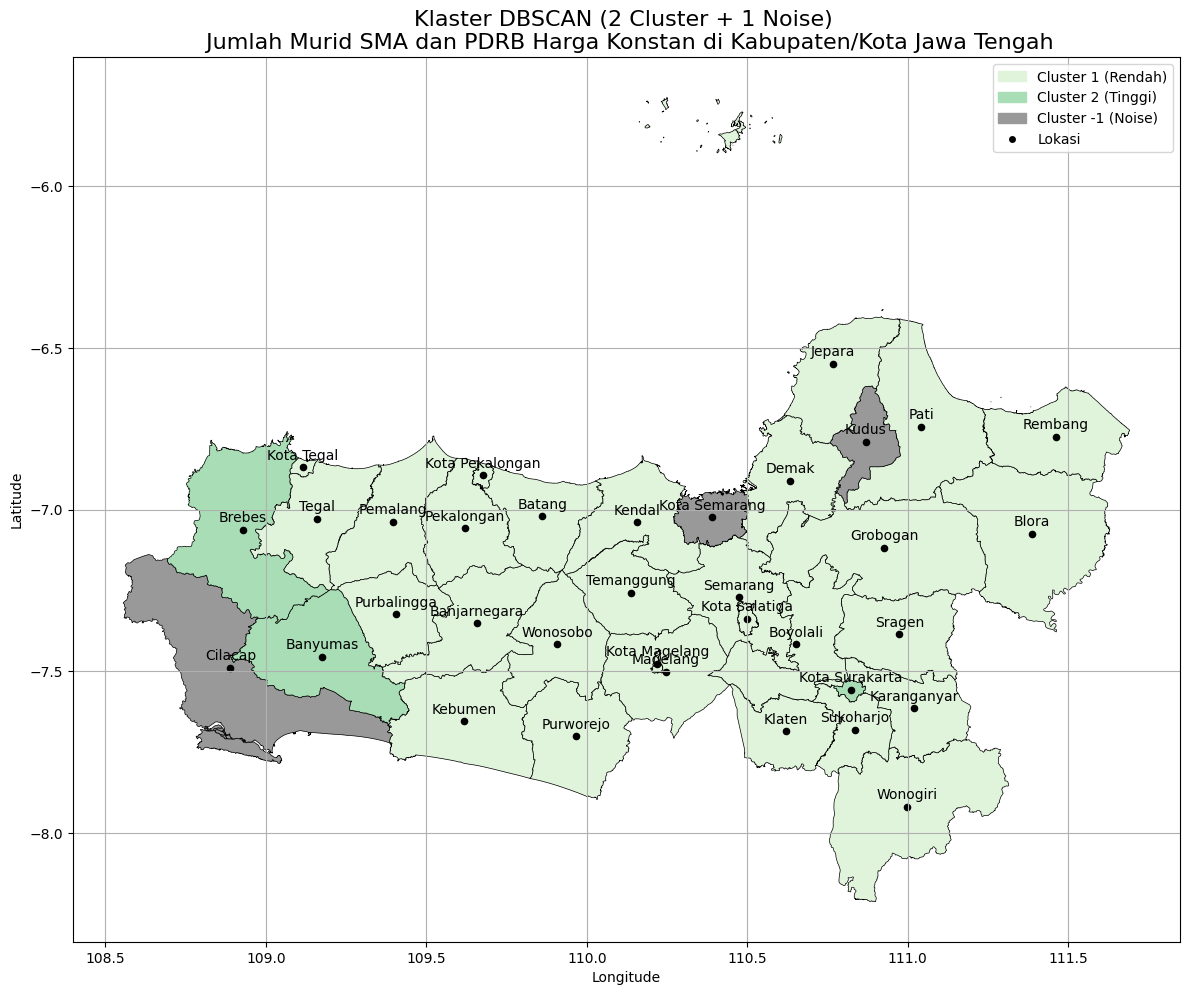

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import joblib
import numpy as np

# Load data normalisasi
case_data = pd.read_csv("../../Dataset/data_normalized.csv")

# Fitur untuk clustering
X_scaled = case_data[['Jumlah_Murid_SMA', 'PDRB_harga_konstan']]

# Load model DBSCAN
dbscan_model = joblib.load('model/model_dbscan.joblib')

# Prediksi cluster DBSCAN
dbscan_labels = dbscan_model.fit_predict(X_scaled)
case_data['Cluster_DBSCAN'] = dbscan_labels

# Load shapefile batas wilayah
gdf = gpd.read_file("../../Dataset/Lokasi/KAB_KOTA_JATENG.shp") 

# Merge data cluster ke GeoDataFrame berdasarkan kolom 'kab_kota'
merged = gdf.merge(case_data, on="kab_kota")

# Daftar cluster unik, kecuali noise (-1)
unique_clusters = sorted(set(dbscan_labels))
clusters_no_noise = [c for c in unique_clusters if c != -1]

num_clusters = len(clusters_no_noise)

# Warna untuk cluster
colors_list = ['#e0f3db', '#a8ddb5', '#43a2ca']
if num_clusters > len(colors_list):
    # Jika cluster lebih banyak, generate colormap
    cmap = plt.get_cmap('tab20', num_clusters)
    colors = [cmap(i) for i in range(num_clusters)]
else:
    colors = colors_list[:num_clusters]

cluster_colors = {cluster_label: colors[i] for i, cluster_label in enumerate(clusters_no_noise)}

# Warna khusus untuk noise (-1)
cluster_colors[-1] = '#999999'

# Map warna ke data merged
merged['color'] = merged['Cluster_DBSCAN'].map(cluster_colors)

# Deskripsi cluster
cluster_descriptions = {
    0: 'Rendah',
    1: 'Tinggi',
    -1: 'Noise'
}

# Legend patch dengan deskripsi
patches = [
    mpatches.Patch(
        color=cluster_colors[cl],
        label=f'Cluster {cl if cl == -1 else cl + 1} ({cluster_descriptions.get(cl, "Tidak diketahui")})'
    )
    for cl in cluster_colors
]

# Plot peta
fig, ax = plt.subplots(figsize=(12, 10))
merged.plot(ax=ax, color=merged['color'], edgecolor='black', linewidth=0.5)

# Menambahkan titik lokasi
if 'longitude' in merged.columns and 'latitude' in merged.columns:
    ax.scatter(
        merged['longitude'],
        merged['latitude'],
        color='black',
        s=20,
        label='Lokasi'
    )
    # Menambahkan label kab/kota di atas titik
    for i, row in merged.iterrows():
        ax.text(row['longitude'], row['latitude'] + 0.015, row['kab_kota'], fontsize=10, ha='center', va='bottom')

plt.legend(handles=patches + [plt.Line2D([0], [0], marker='o', color='w', label='Lokasi',
                                         markerfacecolor='black', markersize=6)], loc='best')

plt.title("Klaster DBSCAN (2 Cluster + 1 Noise) \n Jumlah Murid SMA dan PDRB Harga Konstan di Kabupaten/Kota Jawa Tengah", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

plt.savefig('../../Output/Peta_klaster_DBSCAN.png', format='png', dpi=600)

plt.show()
